In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import seaborn as sns

# **Features:**

HomeTeam = Home Team

AwayTeam = Away Team

FTHG = Full Time Home Team Goals

FTAG = Full Time Away Team Goals

HTR = Half Time Result (H=Home Win, D=Draw, A=Away Win)

HTHG = Half Time Home Team Goals

HTAG = Half Time Away Team Goals

HS = Home Team Shots

AS = Away Team Shots

HST = Home Team Shots on Target

AST = Away Team Shots on Target

HF = Home Team Fouls Committed

AF = Away Team Fouls Committed

HY = Home Team Yellow Cards

AY = Away Team Yellow Cards

HR = Home Team Red Cards

AR = Away Team Red Cards

In [3]:
points = pd.read_csv('EPLStandings.csv')
file_names = ['E1011.csv', 'E1112.csv', 'E1314.csv', 'E1415.csv', 'E1516.csv', 'E1617.csv', 'E1718.csv', 'E1819.csv', 'E1920.csv']
features = ['HomeTeam', 'AwayTeam', 'HTHG', 'HTAG', 'FTHG', 'FTAG', 'HTR', 'HS', 'AS','HST', 'AST', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR']
seasons, data_frames, team_names  = [], {}, []

games_per_season = 380
teams_per_season = 20

for i in file_names: 
  seasons.append(i[1:3] + '-' + i[3:5])

for i in file_names: 
  season = seasons[file_names.index(i)]
  temp_read = pd.read_csv(i)
  temp_write = pd.DataFrame()
  for j in features:
    temp_write.insert(features.index(j), j, temp_read[j])
  data_frames[season] = temp_write

# delete redundant NaN row from end of 14-15 season dataframe
data_frames['14-15'].drop(data_frames['14-15'].tail(1).index, inplace=True)

# one-hot encoding for HTR
for i in data_frames:
  ind = data_frames[i].columns.get_loc('HTR')
  col = data_frames[i]['HTR']
  one_hot = pd.get_dummies(col)
  data_frames[i] = data_frames[i].drop('HTR', axis=1)
  data_frames[i].insert(ind, 'HTR_H', one_hot['H'])
  data_frames[i].insert(ind+1, 'HTR_D', one_hot['D'])
  data_frames[i].insert(ind+2, 'HTR_A', one_hot['A'])

# Display null counts
for i in seasons:
  print('Null valuess for {} season: {}'.format(i, data_frames[i].isnull().sum().sum()))

Null valuess for 10-11 season: 0
Null valuess for 11-12 season: 0
Null valuess for 13-14 season: 0
Null valuess for 14-15 season: 0
Null valuess for 15-16 season: 0
Null valuess for 16-17 season: 0
Null valuess for 17-18 season: 0
Null valuess for 18-19 season: 0
Null valuess for 19-20 season: 0


In [4]:
'''
 Process and organize stats by season by team and average stats per game, rather than by game
 
 Dictionary agg_data holds dictionaries for each season, labels for each team contain list of avg stats listed below
'''

home_features = ['HTHG', 'HTAG', 'FTHG', 'FTAG', 'HTR_H', 'HTR_D', 'HTR_A', 'HS', 'HST', 'HF', 'HY', 'HR']
away_features = ['HTHG', 'HTAG', 'FTHG', 'FTAG', 'HTR_H', 'HTR_D', 'HTR_A', 'AS', 'AST', 'AF', 'AY', 'AR']

agg_data = {}

for i in seasons:
  agg_data[i] = {}

# for each season
for i in data_frames:
  ''' teams[TeamName] = [avg ht goals scored, 
                         avg ht goals conceded, 
                         avg goals scored, 
                         avg goals conceded, 
                         avg ht result (categorical), 
                         avg shots, 
                         avg shots on target, 
                         avg fouls,
                         avg yellow,
                         avg red]
  '''
  teams = {}
  season = data_frames[i]
  
  for j in range(games_per_season):
    # home team stats
    team = season['HomeTeam'][j]

    # list team names
    if team not in team_names:
      team_names.append(team)

    if team in teams:
      for k in home_features:
        teams[team][home_features.index(k)] += season[k][j]

    else:
      teams[team] = []
      for k in home_features:
        teams[team].append(season[k][j])

  for j in range(games_per_season):
    # away team stats
    # swap home / away for:  'HTHG', 'HTAG', 'FTHG', 'FTAG', 'HTR_H', 'HTR_A'
    team = season['AwayTeam'][j]

    to_swap = {'HTHG': season['HTAG'][j], 
               'HTAG': season['HTHG'][j], 
               'FTHG': season['FTAG'][j], 
               'FTAG': season['FTHG'][j], 
               'HTR_H': season['HTR_A'][j], 
               'HTR_A': season['HTR_H'][j]}

    for k in away_features:
      if k in to_swap:
        teams[team][away_features.index(k)] += to_swap[k]
      else:
        teams[team][away_features.index(k)] += season[k][j]

  # divide values by 38 games for avg
  for j in teams:
    for k in range(len(teams[j])):
      teams[j][k] /= 38


  agg_data[i] = teams

# add target column to every row with final point values=
targets = {}
for i in seasons:
  targets[i] = {}

for i in range(len(points['Season'])):
  s = points['Season'][i][2:7]
  t = points['Team'][i]
  targets[s][t] = points['Pts'][i]

for i in seasons:
  for j in targets[i]:
    agg_data[i][j].append(targets[i][j])

# dataframe of data stripped of season and team name

data_list = []
names = ['ht_goals_scored', 
         'ht_goals_conceded', 
          'goals_scored', 
          'goals_conceded', 
          'ht_W', 
          'ht_D',
          'ht_L',
          'shots', 
          'shots_on_target', 
          'fouls',
          'yellow',
          'red',
          'pts']

for i in agg_data:
  for j in agg_data[i]:
    data_list.append(agg_data[i][j])

data = pd.DataFrame(data_list, columns=names)
cols = list(data.columns.values)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ht_goals_scored    180 non-null    float64
 1   ht_goals_conceded  180 non-null    float64
 2   goals_scored       180 non-null    float64
 3   goals_conceded     180 non-null    float64
 4   ht_W               180 non-null    float64
 5   ht_D               180 non-null    float64
 6   ht_L               180 non-null    float64
 7   shots              180 non-null    float64
 8   shots_on_target    180 non-null    float64
 9   fouls              180 non-null    float64
 10  yellow             180 non-null    float64
 11  red                180 non-null    float64
 12  pts                180 non-null    int64  
dtypes: float64(12), int64(1)
memory usage: 18.4 KB


In [6]:
data.head(10)

,ht_goals_scored,ht_goals_conceded,goals_scored,goals_conceded,ht_W,ht_D,ht_L,shots,shots_on_target,fouls,yellow,red,pts
0,0.605263,0.684211,1.263158,1.552632,0.315789,0.421053,0.263158,11.473684,6.342105,11.500000,1.868421,0.052632,48
1,0.605263,0.421053,1.210526,1.552632,0.342105,0.526316,0.131579,10.131579,5.026316,11.973684,1.710526,0.105263,43
2,0.473684,0.552632,1.368421,1.473684,0.236842,0.421053,0.342105,13.105263,7.236842,12.631579,1.763158,0.131579,46
3,0.815789,0.500000,1.815789,0.868421,0.368421,0.421053,0.210526,16.710526,9.052632,10.657895,1.552632,0.026316,71
4,0.552632,0.526316,1.184211,1.473684,0.289474,0.500000,0.210526,11.842105,6.052632,10.605263,1.552632,0.131579,47
5,0.684211,0.684211,1.447368,1.210526,0.263158,0.500000,0.236842,14.736842,8.447368,9.500000,1.342105,0.052632,62
6,0.394737,0.657895,1.052632,1.605263,0.131579,0.500000,0.368421,11.842105,6.657895,12.131579,1.789474,0.105263,42
7,0.578947,0.815789,1.210526,1.736842,0.342105,0.263158,0.394737,9.763158,5.447368,11.526316,1.657895,0.052632,40
8,0.684211,0.394737,1.552632,1.157895,0.368421,0.368421,0.263158,12.500000,7.052632,11.473684,1.657895,0.052632,58
9,0.894737,0.342105,2.052632,0.973684,0.526316,0.342105,0.131579,14.289474,8.157895,10.421053,1.526316,0.078947,80


In [7]:
data.tail(10)

,ht_goals_scored,ht_goals_conceded,goals_scored,goals_conceded,ht_W,ht_D,ht_L,shots,shots_on_target,fouls,yellow,red,pts
170,0.736842,0.657895,1.473684,1.263158,0.368421,0.289474,0.342105,10.789474,3.973684,11.078947,2.263158,0.131579,56
171,0.500000,0.657895,1.078947,1.763158,0.289474,0.368421,0.342105,12.078947,3.947368,11.868421,1.789474,0.026316,35
172,0.421053,0.684211,1.026316,1.421053,0.210526,0.473684,0.315789,12.131579,3.736842,10.131579,1.473684,0.052632,41
173,0.710526,0.605263,1.157895,1.473684,0.315789,0.500000,0.184211,12.368421,4.263158,12.421053,1.842105,0.078947,49
174,0.368421,0.921053,0.684211,1.973684,0.210526,0.315789,0.473684,10.736842,3.447368,9.552632,1.763158,0.078947,21
175,0.578947,0.736842,1.342105,1.578947,0.289474,0.342105,0.368421,13.157895,4.763158,11.842105,1.394737,0.105263,52
176,1.263158,0.447368,2.684211,0.921053,0.552632,0.236842,0.210526,19.605263,6.921053,9.500000,1.578947,0.105263,81
177,0.421053,0.394737,1.026316,1.026316,0.263158,0.473684,0.263158,9.315789,3.026316,10.789474,1.605263,0.052632,54
178,0.947368,0.552632,1.815789,1.421053,0.473684,0.263158,0.263158,16.447368,5.868421,10.157895,1.578947,0.000000,66
179,0.368421,0.684211,1.342105,1.052632,0.184211,0.368421,0.447368,12.078947,3.815789,10.684211,1.500000,0.052632,59


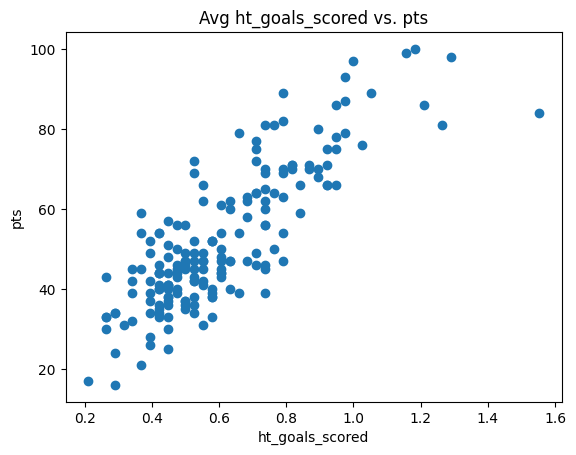

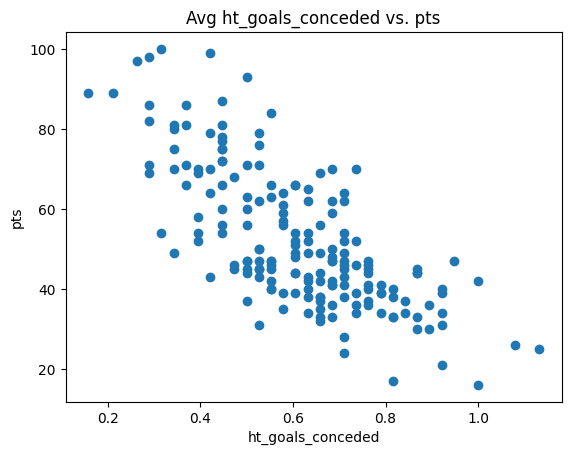

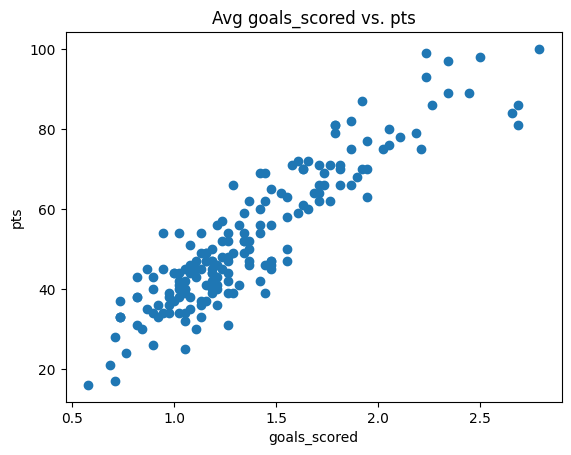

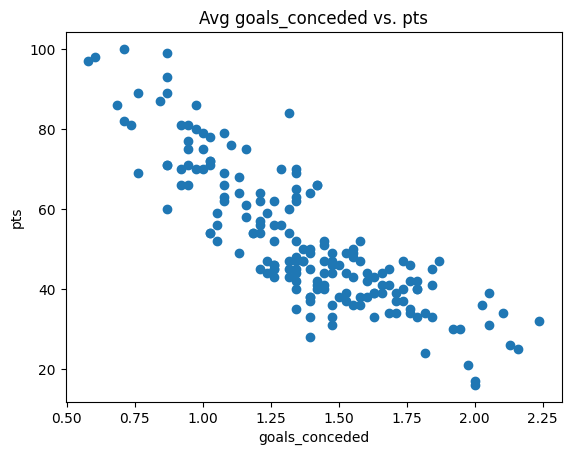

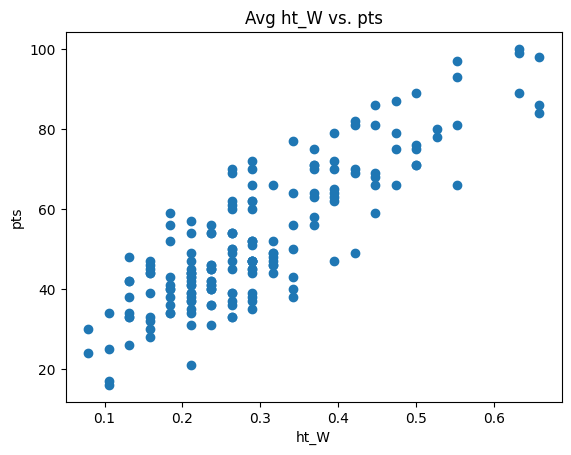

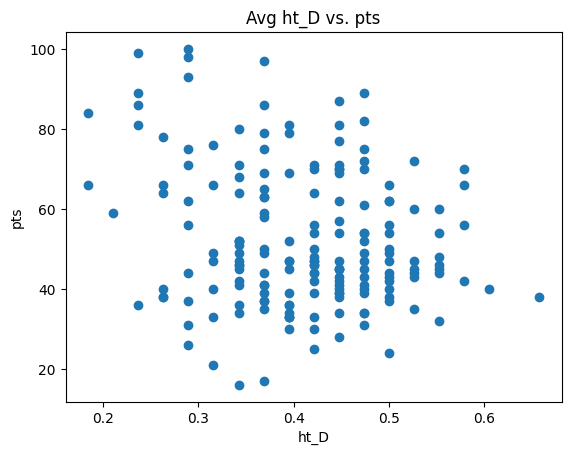

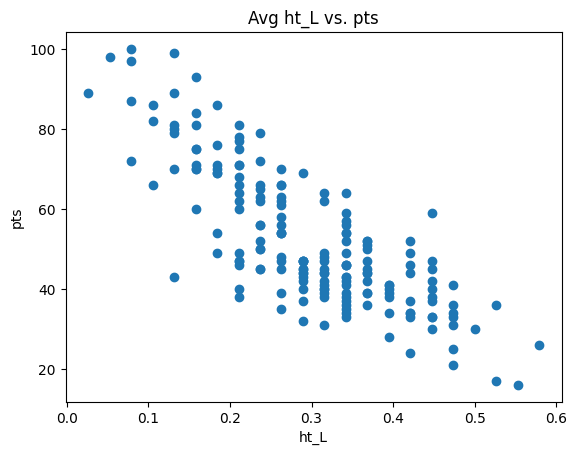

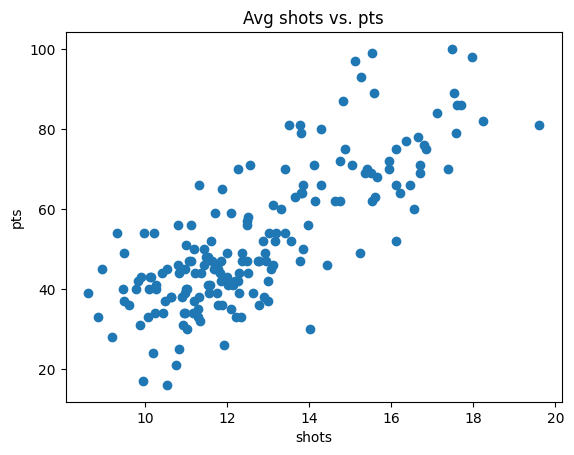

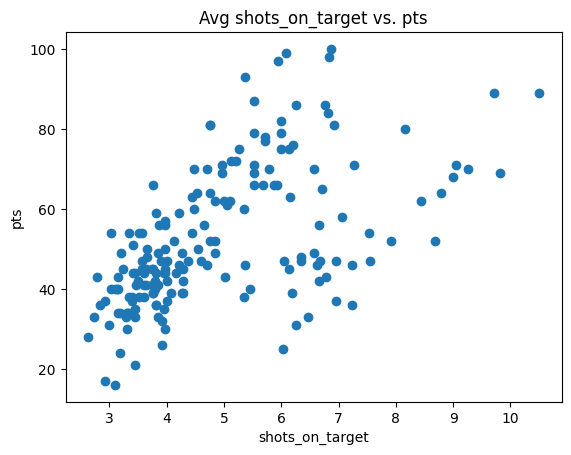

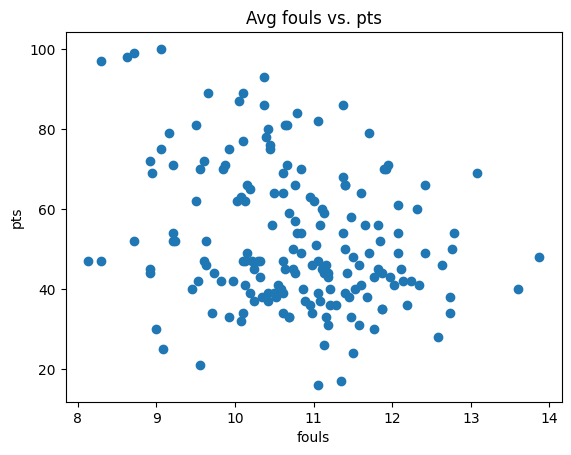

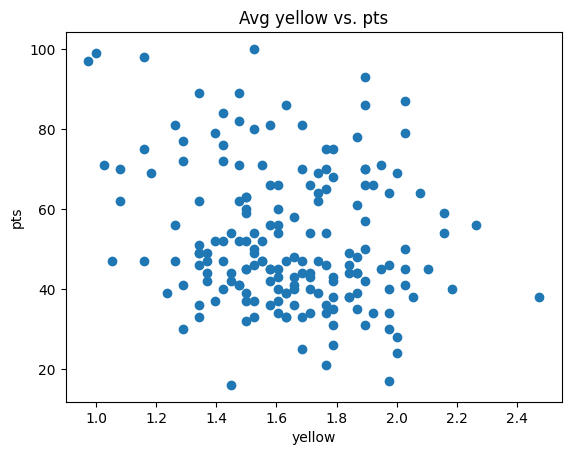

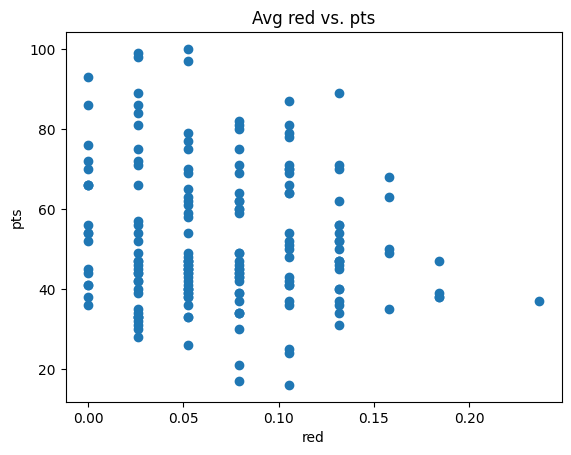

In [8]:
# plot each feature against target value
for i in cols[:12]:
  plt.plot(data[i], data[cols[-1]], 'o', label=col)
  plt.xlabel(i)
  plt.ylabel(cols[-1])
  plt.title('Avg {} vs. {}'.format(i, cols[-1]))
  plt.show()

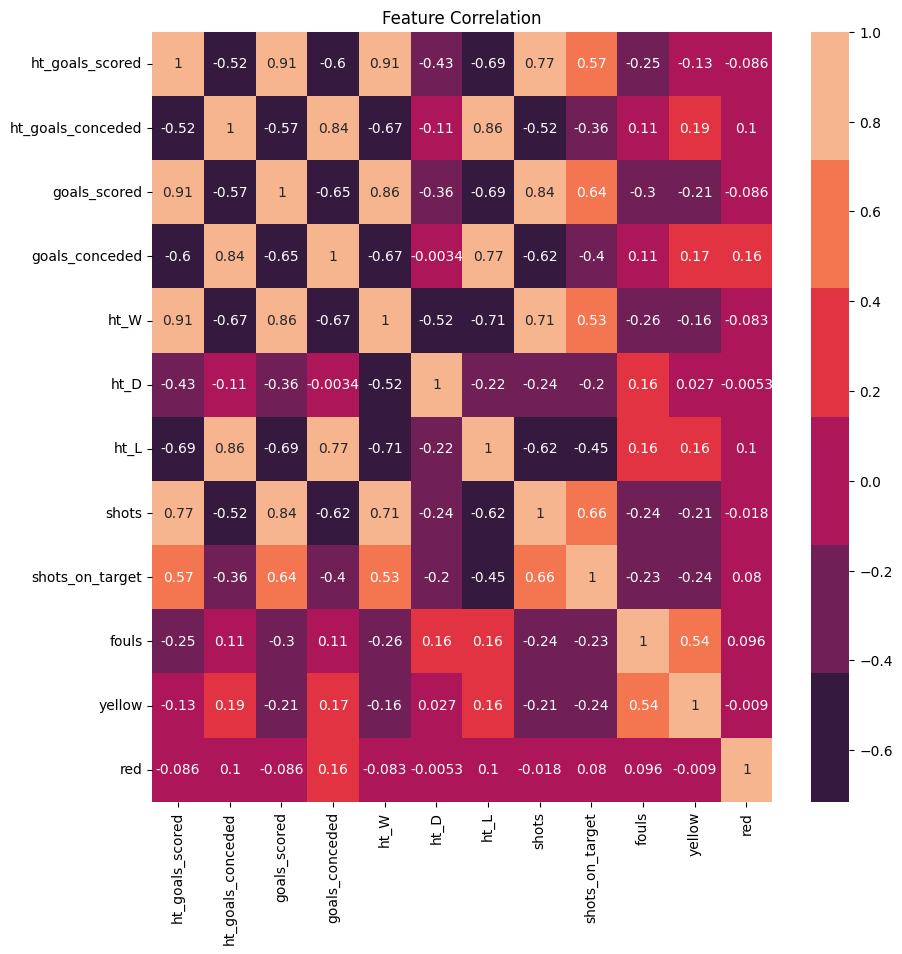

In [9]:
X = data.iloc[:, :12]
y = data['pts']

corr = X.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr,annot=True, cmap=sns.color_palette("rocket"),edgecolor="k")
plt.title("Feature Correlation")
plt.show()

# Neural Network Regressor Training & Testing

**Default Sklearn Neural Network Structure of 2 hidden layers, each with 100 neurons**

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.

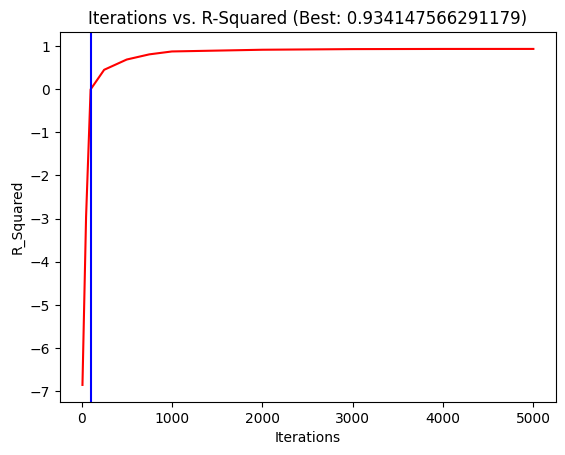

In [37]:
iters = [10, 50, 100, 250, 500, 750, 1000, 2000, 3000, 4000, 5000]
r_squared = []

for i in iters:
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
  regr = MLPRegressor(random_state=1, max_iter=i).fit(X_train, y_train)
  regr.predict(X_test[:2])
  r_squared.append(regr.score(X_test, y_test))

plt.plot(iters, r_squared, 'r-')
plt.xlabel('Iterations')
plt.ylabel('R_Squared')
plt.title('Iterations vs. R-Squared (Best: {})'.format(max(r_squared)))
plt.axvline(x=100, color='b')
plt.show()

In [ ]:
results = {}
for i in seasons:
  results[i] = {}
for i in seasons:
  for j in agg_data[i]:
    actual = agg_data[i][j][-1]
    p = np.array(agg_data[i][j][:12]).reshape(1, -1)
    predicted = regr.predict(p)
    results[i][j] = (actual, predicted[0])

results_final = {}
for i in seasons:
  results_final[i] = []
for i in results:
  for j in results[i]:
    results_final[i].append([j, results[i][j][1], results[i][j][0]])

results_df = []
for i in results_final:
  results_df.append(pd.DataFrame(results_final[i], columns=['Team', 'Predicted', 'Actual']))

In [30]:
results_df[0] = results_df[0].sort_values('Actual', ascending=False)
print('2010-2011 Season')
results_df[0].head(20)

2010-2011 Season


,Team,Predicted,Actual
9,Man United,80.527552,80
18,Man City,71.256303,71
3,Chelsea,71.288612,71
10,Arsenal,68.056115,68
5,Tottenham,56.375470,62
8,Liverpool,60.640893,58
12,Everton,51.216250,54
16,Fulham,54.978732,49
0,Aston Villa,48.368885,48
14,West Brom,39.867161,47


In [31]:
results_df[1] = results_df[1].sort_values('Actual', ascending=False)
print('2011-2012 Season')
results_df[1].head(20)

2011-2012 Season


,Team,Predicted,Actual
18,Man United,87.901062,89
8,Man City,92.259131,89
9,Arsenal,64.457834,70
19,Tottenham,65.062093,69
3,Newcastle,59.008520,65
11,Chelsea,60.034857,64
12,Everton,57.087674,56
2,Liverpool,52.512315,52
1,Fulham,49.191828,52
16,Norwich,43.038352,47


In [14]:
results_df[2] = results_df[2].sort_values('Actual', ascending=False)
print('2013-2014 Season')
results_df[2].head(20)

2013-2014 Season


,Team,Predicted,Actual
9,Man City,94.040344,86
1,Liverpool,82.599539,84
7,Chelsea,77.623302,82
0,Arsenal,71.703323,79
11,Everton,65.524689,72
18,Tottenham,55.482915,69
19,Man United,64.665293,64
15,Southampton,56.231160,56
16,Stoke,47.458732,50
14,Newcastle,44.716862,49


In [15]:
results_df[3] = results_df[3].sort_values('Actual', ascending=False)
print('2014-2015 Season')
results_df[3].head(20)

2014-2015 Season


,Team,Predicted,Actual
11,Chelsea,80.141677,87
19,Man City,79.240762,79
0,Arsenal,72.268158,75
2,Man United,67.739415,70
18,Tottenham,54.865195,64
7,Liverpool,57.876748,62
14,Southampton,63.340979,60
15,Swansea,50.556987,56
4,Stoke,49.684114,54
12,Crystal Palace,46.481833,48


In [16]:
results_df[4] = results_df[4].sort_values('Actual', ascending=False)
print('2015-2016 Season')
results_df[4].head(20)

2015-2016 Season


,Team,Predicted,Actual
3,Leicester,75.176270,81
6,Arsenal,68.619386,71
14,Tottenham,69.802751,70
4,Man United,65.302752,66
18,Man City,67.795983,66
11,Southampton,64.638434,63
16,West Ham,61.870940,62
19,Liverpool,59.988844,60
8,Stoke,44.709484,51
1,Chelsea,54.464902,50


In [17]:
results_df[5] = results_df[5].sort_values('Actual', ascending=False)
print('2016-2017 Season')
results_df[5].head(20)

2016-2017 Season


,Team,Predicted,Actual
9,Chelsea,89.077514,93
14,Tottenham,85.159483,86
4,Man City,77.304527,78
19,Liverpool,74.972193,76
7,Arsenal,74.208495,75
10,Man United,66.555943,69
2,Everton,62.658897,61
6,Southampton,48.380487,46
8,Bournemouth,45.928701,46
16,West Brom,47.751040,45


In [18]:
results_df[6] = results_df[6].sort_values('Actual', ascending=False)
print('2017-2018 Season')
results_df[6].head(20)

2017-2018 Season


,Team,Predicted,Actual
18,Man City,101.976724,100
8,Man United,80.108929,81
17,Tottenham,74.152185,77
13,Liverpool,80.509338,75
2,Chelsea,66.721995,70
0,Arsenal,64.911608,63
11,Burnley,50.892254,54
4,Everton,46.032517,49
12,Leicester,51.004186,47
10,Bournemouth,43.016322,44


In [19]:
results_df[7] = results_df[7].sort_values('Actual', ascending=False)
print('2018-2019 Season')
results_df[7].head(20)

2018-2019 Season


,Team,Predicted,Actual
18,Man City,96.172126,98
8,Liverpool,96.437737,97
11,Chelsea,71.571763,72
14,Tottenham,70.524670,71
7,Arsenal,67.527145,70
0,Man United,59.690939,66
6,Wolves,50.841698,57
12,Everton,55.830555,54
15,West Ham,51.862645,52
13,Leicester,51.477508,52


In [20]:
results_df[8] = results_df[8].sort_values('Actual', ascending=False)
print('2019-2020 Season')
results_df[8].head(20)

2019-2020 Season


,Team,Predicted,Actual
0,Liverpool,87.950545,99
16,Man City,86.595344,81
18,Chelsea,61.214629,66
9,Man United,72.329127,66
7,Leicester,67.377248,62
6,Tottenham,61.152024,59
19,Wolves,56.670289,59
10,Arsenal,57.704296,56
3,Burnley,50.891514,54
17,Sheffield United,53.501820,54


# Predicting The Current Season

In [35]:
current = pd.read_csv('ECurrent.csv')
current_clean = pd.DataFrame()

games_played = 296
season = '22-23'
for i in features:
  current_clean.insert(features.index(i), i, current[i])

ind = current.columns.get_loc('HTR')
col = current['HTR']
one_hot = pd.get_dummies(col)
current_clean = current_clean.drop('HTR', axis=1)
current_clean.insert(ind, 'HTR_H', one_hot['H'])
current_clean.insert(ind+1, 'HTR_D', one_hot['D'])
current_clean.insert(ind+2, 'HTR_A', one_hot['A'])

home_features = ['HTHG', 'HTAG', 'FTHG', 'FTAG', 'HTR_H', 'HTR_D', 'HTR_A', 'HS', 'HST', 'HF', 'HY', 'HR']
away_features = ['HTHG', 'HTAG', 'FTHG', 'FTAG', 'HTR_H', 'HTR_D', 'HTR_A', 'AS', 'AST', 'AF', 'AY', 'AR']


teams = {}

for j in range(games_played):
  # home team stats
  team = current_clean['HomeTeam'][j]

  if team in teams:
    for k in home_features:
      teams[team][home_features.index(k)] += current_clean[k][j]

  else:
    teams[team] = []
    for k in home_features:
      teams[team].append(current_clean[k][j])


for j in range(games_played):
  # away team stats
  # swap home / away for:  'HTHG', 'HTAG', 'FTHG', 'FTAG', 'HTR_H', 'HTR_A'
  team = current_clean['AwayTeam'][j]

  to_swap = {'HTHG': current_clean['HTAG'][j], 
              'HTAG': current_clean['HTHG'][j], 
              'FTHG': current_clean['FTAG'][j], 
              'FTAG': current_clean['FTHG'][j], 
              'HTR_H': current_clean['HTR_A'][j], 
              'HTR_A': current_clean['HTR_H'][j]}

  for k in away_features:
    if k in to_swap:
      teams[team][away_features.index(k)] += to_swap[k]
    else:
      teams[team][away_features.index(k)] += current_clean[k][j]

for j in teams:
  for k in range(len(teams[j])):
    teams[j][k] /= (games_played / 20)

data_list = []
names = ['ht_goals_scored', 
         'ht_goals_conceded', 
          'goals_scored', 
          'goals_conceded', 
          'ht_W', 
          'ht_D',
          'ht_L',
          'shots', 
          'shots_on_target', 
          'fouls',
          'yellow',
          'red']

for j in teams:
  data_list.append(teams[j])

data = pd.DataFrame(data_list, columns=names)
cols = list(data.columns.values)

regr = MLPRegressor(random_state=1, max_iter=100).fit(X_train, y_train)


results = {}
for j in teams:
  p = np.array(teams[j][:12]).reshape(1, -1)
  predicted = regr.predict(p)
  results[j] = predicted[0]
results_final = []
for i in results:
  results_final.append([i, results[i]])

results_df = pd.DataFrame(results_final, columns=['Team', 'Predicted'])

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarnin

In [36]:
results_df = results_df.sort_values('Predicted', ascending=False)
print('Predicted 2022-2023 Season')
results_df.head(20)

Predicted 2022-2023 Season


,Team,Predicted
11,Arsenal,92.457777
13,Man City,90.673106
5,Tottenham,89.857748
19,Liverpool,89.117420
8,Man United,87.792983
12,Brighton,86.640760
3,Leeds,84.465512
4,Newcastle,83.709225
18,Chelsea,80.510791
10,Aston Villa,79.301195
